# Algorytm genetyczny - częściowa implementacja NEAT

## Aleksandra Wichrowska, 291140

"Potwierzam samodzielność poniższej pracy i niekorzystanie przeze mnie z niedozwolonych źródeł." 

~ Aleksandra Wichrowska

In [1]:
import numpy as np

### Node gene class

In [81]:
class Node:
    
    def __init__ (self, node_id, node_type):
        """
        node_id [int]: global ID of node
        node_type [str]: one of {'input','output','hidden'}
        """
        self.node_id = node_id 
        self.node_type = node_type

### Connection gene class

In [82]:
class Connection:
    
    def __init__(self, node_in, node_out, weight, enabled, innov):
        """
        node_in [Node]: first node in connections
        node_out [Node]: second node in connections
        weight [float]: connection weight
        enabled [boolean]: True if connections is enabled
        innov [int]: gloabl ID of connection
        """
        self.node_in = node_in
        self.node_out = node_out
        self.weight = weight
        self.enabled = enabled
        self.innov = innov
    
    def get_connection_nodes_ids(self):
        """
        returns tuple of connection nodes ids
        """
        return (self.node_in.node_id, self.node_out.node_id)

### Individual class

In [83]:
class Individual:
    
    def __init__ (self, nodes, connections):
        """
        nodes [list]: list of nodes
        connections [list]: list of connections
        """
        self.nodes = nodes
        self.connections = connections
        
    def get_connections_list(self):
        """
        returns list of individual's connections, 
        each connections is represented as a tuple of nodes ids
        """
        connections_list = []
        for connection in self.connections:
            connections_list.append(connection.get_connection_nodes_ids())
        return connections_list
    
    def get_enabled_connections(self):
        """
        returns list of individual's enabled connections 
        """
        connections_list = []
        for connection in self.connections:
            if connection.enabled: connections_list.append(connection)
        return connections_list

### Genetic algorithm (NEAT) class

In [84]:
class GeneticAlgorithm:
    
    def __init__ (self, size, n_in, n_out):
        """
        size [int]: size of population (number of individuals)
        n_in [int]: number of input nodes
        n_out [int]: number of output nodes
        """
    
        self.size = size 
        self.n_in = n_in
        self.n_out = n_out
        self.connections = {} # dictionary with tuples of connections nodes ids as keys
        self.n_nodes = 0 # counter of nodes
        self.population = self.generate_population()
        
    def generate_population(self):
        """
        return generated population,
        """
        population = []
        for i in range(self.size):
            population.append(self.generate_simple_individual())
        self.n_nodes += (self.n_in+self.n_out)
        return population
        
    def generate_simple_individual(self):
        """
        return generated individual for start population,
        individual is fully connected graph with only inputs and outputs nodes 
        """
        nodes = []
        connections = []
        max_id = 0
        for i in range(self.n_in):
            nodes.append(Node(max_id + 1, 'input'))
            max_id += 1
        for i in range(self.n_out):
            nodes.append(Node(max_id + 1, 'output'))
            max_id += 1 
        for i in range(self.n_in):
            for j in range(self.n_out):
                connection_nodes = (nodes[i].node_id, nodes[self.n_in+j].node_id)
                if not connection_nodes in self.connections.keys():
                    self.connections[connection_nodes] = {'innov': len(self.connections)+1, 'node_between':None}
                connection = Connection(nodes[i], nodes[self.n_in+j], np.random.normal(), True, 
                                       self.connections[connection_nodes]['innov'])
                connections.append(connection)
            
        new_individual = Individual(nodes, connections)
        return new_individual
        
    def evaluate(self):
        return np.apply_along_axis(self.eval_function, 1, self.population)
    
    ##################################
    ############ MUTATION ############
    ##################################    
    
    def mutate_population(self):
        return
    
    def add_connection_mutation(self, individual):
        """
        add new connections between existing nodes
        
        individual [Individual]: individual selected for mutation
        """
        for trial in range(50):
            n1, n2 = np.random.choice(individual.nodes,2, False)
            if n1.node_type == 'input' and n2.node_type == 'input':
                continue
            elif n1.node_type == 'output' and n2.node_type == 'output':
                continue
            elif (n1.node_id,n2.node_id) in individual.get_connections_list():
                continue
            else:    
                if not (n1.node_id, n2.node_id) in self.connections:
                    self.connections[(n1.node_id,n2.node_id)] = {'innov': len(self.connections)+1, 'node_between':None}
                innov = self.connections[(n1.node_id,n2.node_id)]['innov']
                connection = Connection(n1,n2,np.random.normal(), True, innov)
                individual.connections.append(connection)
                return
        print('Failed connection adding')
        return
    
    def add_node_mutation(self, individual):
        """
        add new node on existing connection
        
        individual [Individual]: individual selected for mutation
        """
        
        # choose enabled connection on which will be added new node
        connection = np.random.choice(individual.get_enabled_connections(),1)[0]
        connection.enabled = False        
        
        # check if on this connections in other individuals exists node
        # if yes - get this node id and connections (to and from it) innov
        if self.connections[connection.get_connection_nodes_ids()].node_between != None:
            new_node_id = self.connections[connection.get_connection_nodes_ids()][1]
            connection1_innov = self.connections[(connection.node_in.node_id, new_node_id)]['innov']
            connection2_innov = self.connections[(new_node_id,connection.node_out.node_id)]['innov']
            
        # if no - create new global node and two new global connections
        else:
            self.n_nodes += 1
            new_node_id = self.n_nodes
            self.connections[connection.get_connection_nodes_ids()].node_between = new_node_id
            connection1_innov = len(self.connections) + 1
            self.connections[(connection.node_in.node_id, new_node_id)] = {'innov': connection1_innov, 'node_between':None}
            connection2_innov = len(self.connections) + 1
            self.connections[(new_node_id, connection.node_out.node_id)] = {'innov': connection2_innov, 'node_between':None}
    
        new_node = Node(new_node_id, 'hidden')
        individual.nodes.append(new_node)
        
        new_connection1 = Connection(connection.node_in, new_node, 1, True, connection1_innov)
        individual.connections.append(new_connection1)
        
        new_connection2 = Connection(new_node, connection.node_out, connection.weight, True, connection2_innov)
        individual.connections.append(new_connection2)
    
    def change_weight_mutation(self, individual):
        """
        change one randomly selected connection
        
        individual [Individual]: individual selected for mutation
        """        
        connection = np.random.choice(individual.get_enabled_connections(),1)[0]
        rand = np.random.uniform()
        
        # with probability 10% set new weight
        if rand <= 0.1:
            connection.weight = np.random.normal()
        
        # with probability 90% perturbate weight
        else:
            connection.weight += 0.1*np.random.normal()

    def disable_connection_mutation(self, individual):
        """
        disable one randomly selected connection
        
        individual [Individual]: individual selected for mutation
        """        
        connection = np.random.choice(individual.get_enabled_connections,1)[0]
        connection.enabled = False
    
    ##################################
    ########### CROSS OVER ###########
    ##################################
    
    def cross_over_populaton(self):
        return
    
    def cross_over_individuals(self):
        
        index1, index2 = np.random.choice(range(len(self.population)), 2, replace=False)
        individual1 = self.population[index1]
        individual2 = self.population[index2]
        
        new_individual_nodes = []
        new_individual_connections = []
        
        for connection in self.connections:
            if connection in individual1.get_connections_list() and connection in individual2.get_connections_list():
                return
            elif connection in individual1.get_connections_list():
                return
            elif connection in individual2.get_connections_list():    
                return
        return
    
    ##################################
    ############ TRAINING ############
    ##################################
        
    def train_one_epoch(self):
        self.cross_over_population()
        self.mutate_population()
        
    def train_population(self, epochs=20):
        results = [min(self.evaluate())]
        for i in range(epochs):
            self.train_one_epoch()
            results.append(min(self.evaluate()))
        return results 

In [85]:
ga = GeneticAlgorithm(10,3,2)

In [86]:
ga.population

In [94]:
ga.population[0].get_connections_list()

[(1, 4), (1, 5), (2, 4), (2, 5), (3, 4), (3, 5)]

In [88]:
ga.population[0].get_enabled_connections()

In [90]:
import networkx as nx

In [98]:
G = nx.Graph()
pos = nx.spring_layout(G) 
G.add_edges_from([(1, 4), (1, 5), (2, 4), (2, 5), (3, 4), (3, 5)])

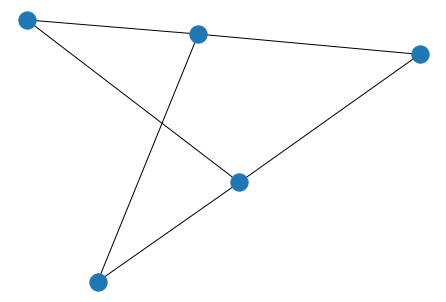

In [97]:
nx.draw(G)